# Active Learning Maximal Expected Error Reduction
> "A programming introduction to Expected Error Reduction Query Strategy in Active Learning with logistic Regression Model."

- toc: true
- badges: true
- comments: true
- author: Sachin Yadav
- categories: [ActiveLearning]

In [27]:
# Common Imports 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib import rc
from tqdm.notebook import tqdm

plt.style.use('fivethirtyeight')
rc('animation', html='jshtml')

# To copy the models
from copy import deepcopy

# Sklearn Imports
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Progress helper
from IPython.display import clear_output


### 2 Class Dataset

In [28]:
class Config:
    # Dataset Generation
    n_features = 2
    n_classes = 2
    n_samples = 1000
    dataset_random_state = 6

    # Active Learning
    test_frac = 0.2
    init_train_size = 20
    model_random_state = 0
    active_learning_iterations = 10

    # Saved GIF
    fps = 8

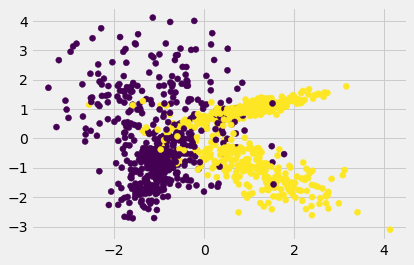

In [3]:
X, y = make_classification(
    n_samples=Config.n_samples,
    n_features=Config.n_features,
    n_informative=Config.n_features,
    n_redundant=0,
    n_classes=Config.n_classes,
    random_state=Config.dataset_random_state,
    shuffle=True,
)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y)

### Full DataFit

In [4]:
model = LogisticRegression(random_state=Config.model_random_state)
model.fit(X, y)

LogisticRegression(random_state=0)

In [5]:
def plot_decision_surface(X, y, model):
    grid_X1, grid_X2 = np.meshgrid(
        np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 1000),
        np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 1000),
    )

    grid_X = [(x1, x2) for x1, x2 in zip(grid_X1.ravel(), grid_X2.ravel())]

    grid_pred = model.predict(grid_X)

    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.contourf(grid_X1, grid_X2, grid_pred.reshape(*grid_X1.shape), alpha=0.2)

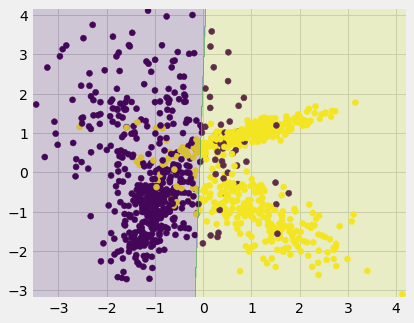

In [6]:
plot_decision_surface(X, y, model)

### Train, Pool, Test Split

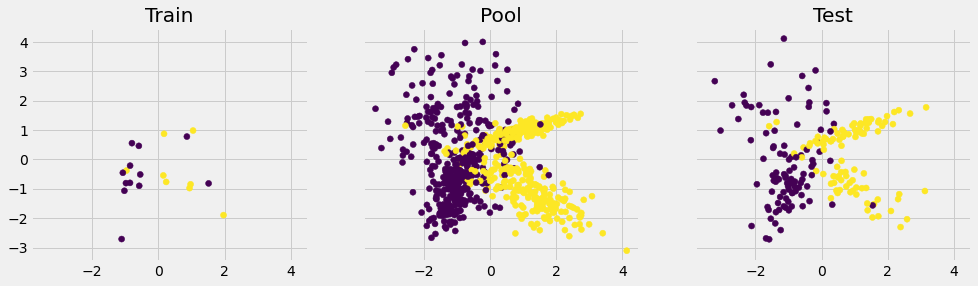

In [7]:
dataset_indices = list(range(len(X)))

train_pool_indices, test_indices = train_test_split(dataset_indices, test_size=Config.test_frac, random_state=0, stratify=y)
train_indices, pool_indices = train_test_split(train_pool_indices, train_size=Config.init_train_size, random_state=0)

indices_list = [train_indices, pool_indices, test_indices]
t_list = ['Train', 'Pool', 'Test']

fig, ax = plt.subplots(1,3,figsize=(15,4), sharex=True, sharey=True)
for i in range(3):
    ax[i].scatter(X[indices_list[i]][:,0], X[indices_list[i]][:,1], c=y[indices_list[i]])
    ax[i].set_title(t_list[i])

### Fitting Model on Initial Train Data

In [8]:
AL_model = LogisticRegression(random_state = Config.model_random_state)
AL_model.fit(X[train_indices], y[train_indices])

LogisticRegression(random_state=0)

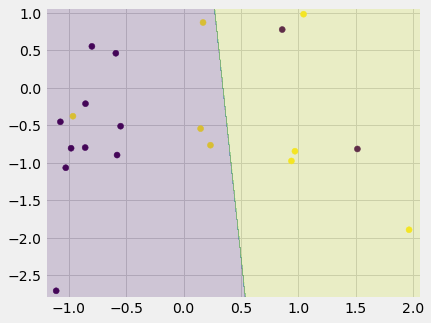

In [9]:
plot_decision_surface(X[train_indices], y[train_indices], AL_model)

## Expected 0/1 Loss

### Calculating expected 0/1 Loss
Expected 0/1 Loss is:   

![](./assets/2022-02-22-maximal-expected-error-reduction-active-learning/01-loss-formula.png)

```
At each iteration:
For each unlabeled pool instance:
    Suppose this instance is labeled and re-train the classifier
    Re-infer the labels of remaining pool instances
    Estimate the expected error
End

Select the instance whose expected error reduction is largest
```

In [10]:
def query_0_1_losses(pl_indices, al_model):
    y_pred_proba = al_model.predict_proba(X[pl_indices])
    expected_01_losses = []

    # For each pool instance
    for row_idx, pl_indx in enumerate(pl_indices):

        new_temp_train_X = X[train_indices + [pl_indx]] 
        new_tmp_pl_indices = pl_indices.copy()
        new_tmp_pl_indices.remove(pl_indx)
        new_temp_pool_X = X[new_tmp_pl_indices]

        expec_01_loss = 0
        for clss in range(Config.n_classes):
            # Add pool instance to the training instance, assuming this class as the label
            
            new_temp_train_y = np.append(y[train_indices], clss)
            clss_proba = y_pred_proba[row_idx][clss]


            # Train the new model 
            new_temp_al_model = LogisticRegression(random_state=Config.model_random_state)
            new_temp_al_model.fit(new_temp_train_X, new_temp_train_y)

            # Re-infer the remaining pool indices
            new_tmp_y_pred_proba = new_temp_al_model.predict_proba(new_temp_pool_X)
            new_tmp_y_pred = new_temp_al_model.predict(new_temp_pool_X)
            new_tmp_y_pred_class_proba = new_tmp_y_pred_proba[range(len(new_tmp_pl_indices)), new_tmp_y_pred]

            # Calculate expected loss
            loss = np.sum(1 - new_tmp_y_pred_class_proba)

            expec_01_loss += clss_proba * loss


        expected_01_losses.append(expec_01_loss)

    # Select instance with lowest expected error
    return pl_indices[np.argmin(expected_01_losses)]

### Create test-pool copies for Maximal ERR and Random Strategy

In [11]:
al_train_indices = train_indices.copy()
al_test_indices = test_indices.copy()
al_pool_indices = pool_indices.copy()

random_train_indices = train_indices.copy()
random_test_indices = test_indices.copy()
random_pool_indices = pool_indices.copy()

## Run Active Learning

In [12]:
AL_models = []
random_models = []
AL_added_indices = []
random_added_indices = []

np.random.seed(0)

for active_iteration in tqdm(range(Config.active_learning_iterations)):

    ##### Maximal Expected Error Reduction Strategy ######
    # Fit model
    AL_model = LogisticRegression(random_state = Config.model_random_state)
    AL_model.fit(X[al_train_indices], y[al_train_indices])
    AL_models.append(deepcopy(AL_model))

    # Query a point
    query_idx = query_0_1_losses(al_pool_indices, AL_model)
    AL_added_indices.append(query_idx)

    # Add query index to train indices and remove from pool indices
    al_train_indices.append(query_idx)
    al_pool_indices.remove(query_idx)


    ##### Random Strategy #####
    # Fit model
    random_model = LogisticRegression(random_state = Config.model_random_state)
    random_model.fit(X[random_train_indices], y[random_train_indices])
    random_models.append(deepcopy(random_model))

    # Query a point
    query_idx = np.random.choice(random_pool_indices)
    random_added_indices.append(query_idx)

    # Add query index to train indices and remove from pool indices
    random_train_indices.append(query_idx)
    random_pool_indices.remove(query_idx)

  0%|          | 0/10 [00:00<?, ?it/s]

### Plot Accuracy

iteration 9


Text(0, 0.5, 'Accuracy\n(Higher is better)')

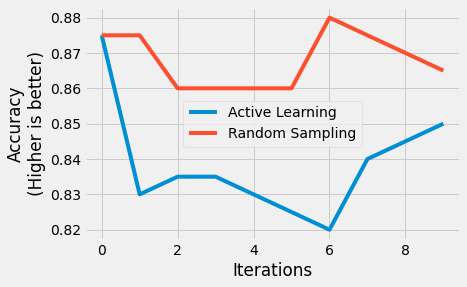

In [14]:
X_test = X[test_indices]
y_test = y[test_indices]
random_scores = []
AL_scores = []
for iteration in range(Config.active_learning_iterations):
    clear_output(wait=True)
    print("iteration", iteration)
    AL_scores.append(accuracy_score(y_test, AL_models[iteration].predict(X_test)))
    random_scores.append(accuracy_score(y_test, random_models[iteration].predict(X_test)))
    
plt.plot(AL_scores, label='Active Learning')
plt.plot(random_scores, label='Random Sampling')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy\n(Higher is better)')

## Plot Decision Boundaries

In [20]:
grid_X1, grid_X2 = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 1000),
    np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 1000),
)

grid_X = [(x1, x2) for x1, x2 in zip(grid_X1.ravel(), grid_X2.ravel())]

In [21]:
X_train, y_train = X[al_train_indices], y[al_train_indices]
X_train_rand, y_train_rand = X[random_train_indices], y[random_train_indices]

In [22]:
def update(i):
    for each in ax:
        each.cla()
        
    AL_grid_preds = AL_models[i].predict(grid_X)
    random_grid_preds = random_models[i].predict(grid_X)
    
    # Active learning
    ax[0].scatter(X_train[:n_train,0], X_train[:n_train,1], c=y_train[:n_train], label='initial_train', alpha=0.2)
    ax[0].scatter(X_train[n_train:n_train+i, 0], X_train[n_train:n_train+i, 1], 
                  c=y_train[n_train:n_train+i], label='new_points')
    ax[0].contourf(grid_X1, grid_X2, AL_grid_preds.reshape(*grid_X1.shape), alpha=0.2);
    ax[0].set_title('New points')
    
    ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, label='test_set')
    ax[1].contourf(grid_X1, grid_X2, AL_grid_preds.reshape(*grid_X1.shape), alpha=0.2);
    ax[1].set_title('Test points');
    ax[0].text(locs[0],locs[1],'Active Learning')
    
    # Random sampling
    ax[2].scatter(X_train_rand[:n_train,0], X_train_rand[:n_train,1], c=y_train_rand[:n_train], label='initial_train', alpha=0.2)
    ax[2].scatter(X_train_rand[n_train:n_train+i, 0], X_train_rand[n_train:n_train+i, 1], 
                  c=y_train_rand[n_train:n_train+i], label='new_points')
    ax[2].contourf(grid_X1, grid_X2, random_grid_preds.reshape(*grid_X1.shape), alpha=0.2);
    ax[2].set_title('New points')
    
    ax[3].scatter(X_test[:, 0], X_test[:, 1], c=y_test, label='test_set')
    ax[3].contourf(grid_X1, grid_X2, random_grid_preds.reshape(*grid_X1.shape), alpha=0.2);
    ax[3].set_title('Test points');
    ax[2].text(locs[0],locs[1],'Random Sampling');

In [29]:
locs = (2.7, 4)
fig, ax = plt.subplots(2,2,figsize=(12,6), sharex=True, sharey=True)
ax = ax.ravel()
n_train = X_train.shape[0] - Config.active_learning_iterations

anim = FuncAnimation(fig, func=update, frames=range(Config.active_learning_iterations))
plt.close()
anim

FileNotFoundError: [Errno 2] No such file or directory: '/assets/2022-02-22-maximal-expected-error-reduction-active-learning/active-learning.gif'

In [35]:
mywriter = animation.PillowWriter(fps=Config.fps)
anim.save('./assets/2022-02-22-maximal-expected-error-reduction-active-learning/active-learning.gif',writer=mywriter)